### Import library

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

### Import dataset 

In [148]:
dfHouse = pd.read_csv('House_Rent_Dataset.csv')
dfHouse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [149]:
from scipy import stats


In [150]:
dfHouse = dfHouse[(np.abs(stats.zscore(dfHouse.select_dtypes(['int64' , 'float64'])))<3).all(axis=1)]

In [151]:
x = dfHouse[["Size"]] #menentukan target dengan memilih column target
y = dfHouse[["Rent"]] #menentukan target dengan memilih column target

In [152]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0)


In [154]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [155]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [156]:
y_pred = reg.predict(x_test)

In [157]:
y_score = reg.score(x_test, y_test)
y_score

0.16586658257651965

### Linear Regression

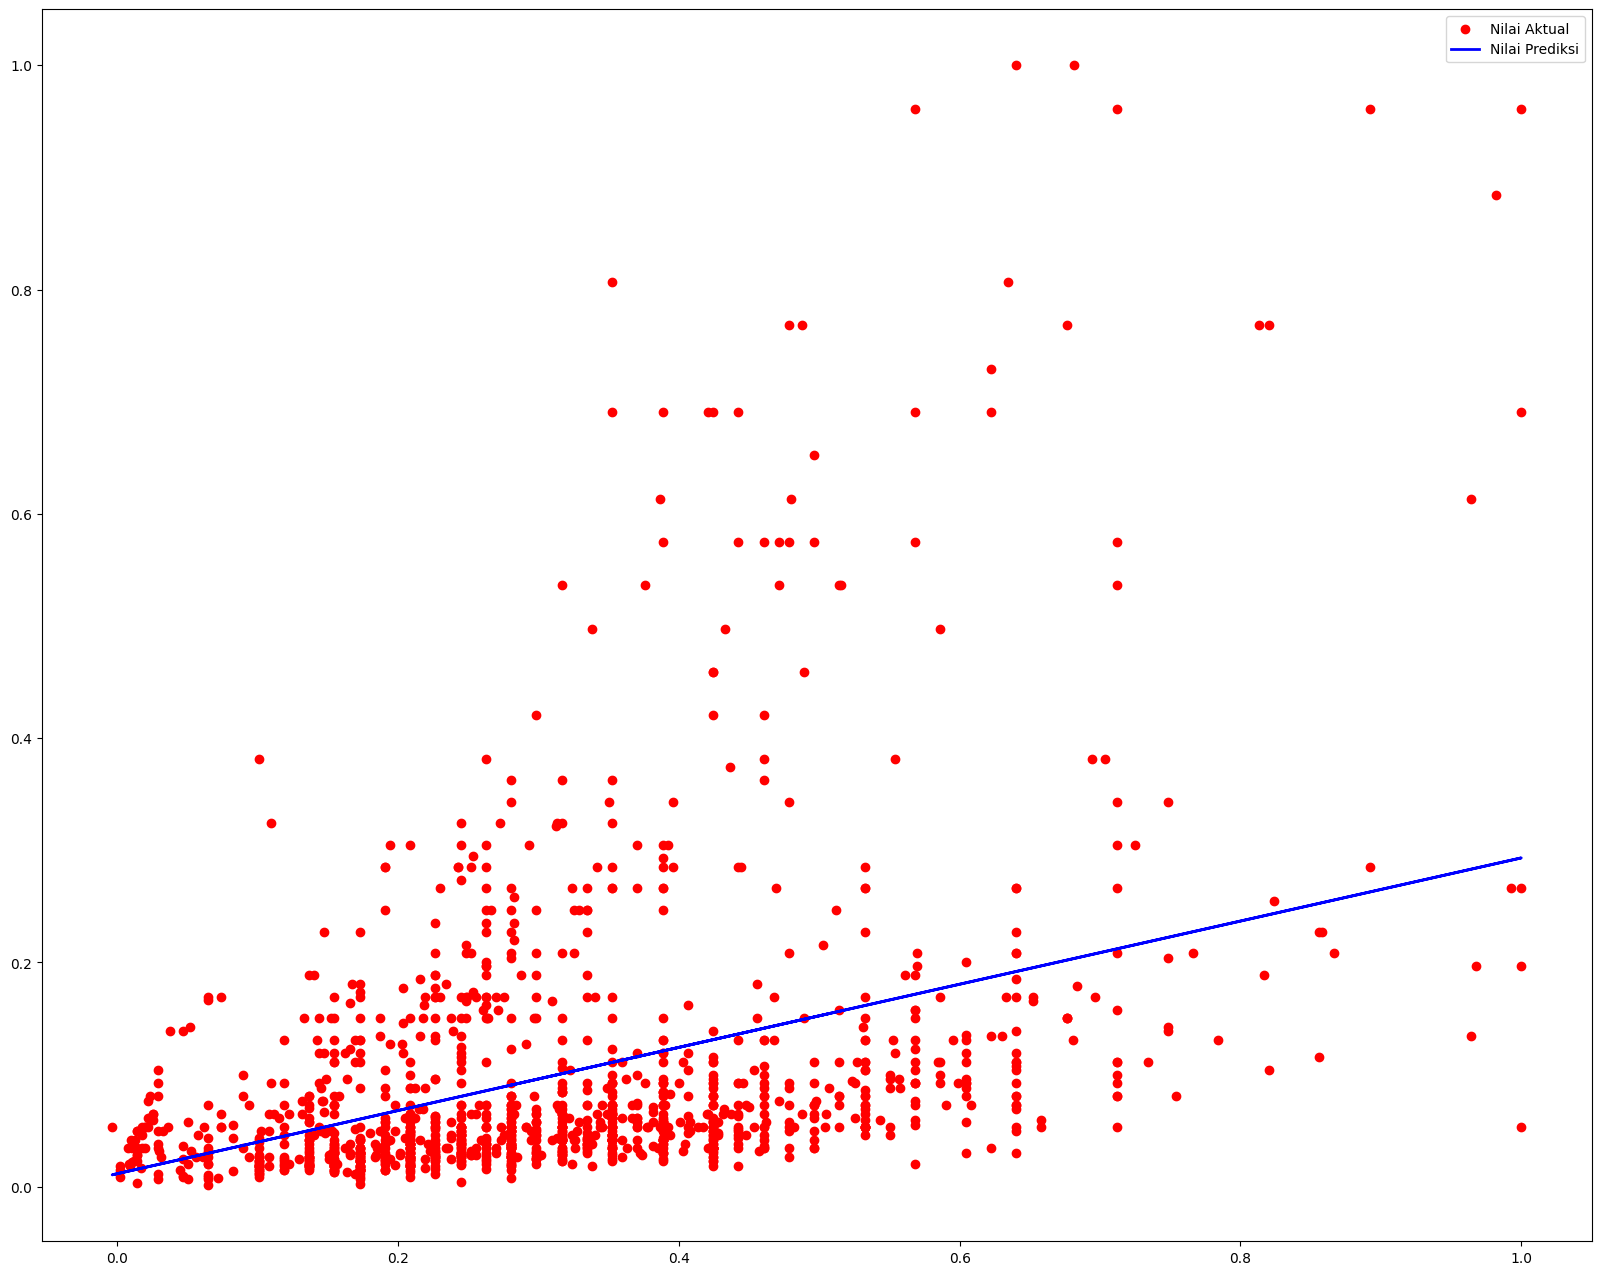

In [158]:
plt.figure(figsize=(20,16))
plt.scatter(x_test, y_test, c="red", label ="Nilai Aktual")
plt.plot(x_test, y_pred, c="blue", linewidth=2, label="Nilai Prediksi")
plt.legend()
# plt.xlabel("Nilai X")
# plt.ylabel("Nilai y")
# plt.title("Prediksi Nilai Y terhadap Nilai X")
plt.show()

### Eval Reg

In [160]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(mae, mse, rmse, r2, sep='\n')

0.07519292515203618
0.0148756348379698
0.12196571173067372
0.16586658257651965
